# Pytorch_Practice_RNN(MNIST)
為什麼圖片可以用RNN?
- 可以想成看圖片時是由圖片最上面往下一列一列看

In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import torchvision.datasets 
import torchvision.transforms
import matplotlib.pyplot as plt

In [2]:
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28  #總共有幾筆序列要輸入
INPUT_SIZE = 28  #每次輸入的資料
LR = 0.01
DOWNLOAD_MNIST = False

In [3]:
train_data = torchvision.datasets.MNIST(
    root = './mnist/',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = DOWNLOAD_MNIST
)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

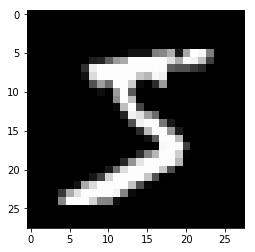

In [4]:
plt.imshow(train_data.train_data[0], cmap='gray')

In [5]:
train_loader = Data.DataLoader(dataset=train_data, shuffle=True, batch_size=BATCH_SIZE)
X_test = test_data.test_data[:2000].type(torch.FloatTensor) / 255.0 
# X_test: (2000, 28, 28)，跟cnn不同(2000, 1, 28, 28)
# rnn 不需要channel
y_test = test_data.test_labels[:2000]

X_test = X_test.cuda()
y_test = y_test.cuda()

In [6]:
# https://zhuanlan.zhihu.com/p/39191116
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=28,  # input pixels
            hidden_size=64,  # numbers of rnn neurons
            num_layers=1,  # numbers of rnn layers
            batch_first=True  # (batch, time_step, input_size)
        )
        self.output = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        r_out, (r_h, r_c) = self.rnn(x, None)
        # x:(batch_size, time_step, input_size)
        # None代表當下沒有要傳入hidden state（預設全部0）
        # r_out代表當下的output，(batch_size, time_step, hidden_size)
        # (r_h, r_c)是當下的hidden state，(num_layer, batch_size, hidden_size)

        out = self.output(
            r_out[:, -1, :])  # r_out紀錄了28筆timestep的output，所以要選取最後一個時刻的output
        return out

In [7]:
rnn = RNN()
rnn.cuda()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()# torch的crossentropyloss不用做onehot

# train
for epoch in range(EPOCH):
    for step, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
      
        # (batch_size, 1, time_step, input_size) -> (batch_size, time_step, input_size)
        # train_loader會自動加上channel的1，所以要去掉
        X_batch = X_batch.view(-1, 28, 28)
        output = rnn(X_batch)
        loss = loss_func(output, y_batch)
        optimizer.zero_grad() # clear gradients
        loss.backward() # calc gradients for each chain(back propagations)
        optimizer.step() # apply gradients
        
        if step % 50 == 0:
            # torch.max回傳兩個tensor，第一個是原tensor的max，第二個是對應的index num
            # index剛好可以對應one-hot，所以可以直接用
            test_output = rnn(X_test)
            pred = torch.max(test_output, dim=1)[1]
            # 有坑注意！不要用sum()，如果要用的話要先讓資料是ndarray type！
            train_acc = torch.sum(pred == y_test).cpu().numpy() / X_test.shape[0]
            train_loss = loss
            print('epoch:', epoch, 'test loss: %.4f' % train_loss, 'test acc:', train_acc)


epoch: 0 test loss: 2.3119 test acc: 0.1025
epoch: 0 test loss: 1.4347 test acc: 0.4425
epoch: 0 test loss: 0.8038 test acc: 0.653
epoch: 0 test loss: 0.9320 test acc: 0.7225
epoch: 0 test loss: 0.7641 test acc: 0.7485
epoch: 0 test loss: 0.2461 test acc: 0.8335
epoch: 0 test loss: 0.2824 test acc: 0.892
epoch: 0 test loss: 0.4507 test acc: 0.878
epoch: 0 test loss: 0.3953 test acc: 0.894
epoch: 0 test loss: 0.0566 test acc: 0.9325
epoch: 0 test loss: 0.2266 test acc: 0.919
epoch: 0 test loss: 0.4125 test acc: 0.837
epoch: 0 test loss: 0.1801 test acc: 0.9265
epoch: 0 test loss: 0.1916 test acc: 0.9235
epoch: 0 test loss: 0.2135 test acc: 0.9335
epoch: 0 test loss: 0.1592 test acc: 0.941
epoch: 0 test loss: 0.2911 test acc: 0.935
epoch: 0 test loss: 0.0400 test acc: 0.946
epoch: 0 test loss: 0.1208 test acc: 0.944


In [9]:
test_output = rnn(X_test[:10])
pred_y = torch.max(test_output, dim=1)[1].cpu().numpy()
print(pred_y, y_test[:10].cpu().numpy())

[7 2 1 0 4 1 4 9 6 9] [7 2 1 0 4 1 4 9 5 9]
